In [31]:
from multiprocessing import cpu_count
import os
import yaml

import numexpr
import numpy as np
import pandas as pd
import scipy.stats as stats
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from scripts.general import attribution, data

tqdm.pandas(desc='Pandas op')
numexpr.set_num_threads(cpu_count() - 2)


def left_align(df: pd.DataFrame):
    """https://stackoverflow.com/a/63869860"""
    left_aligned_df = df.style.set_properties(**{'text-align': 'left'})
    left_aligned_df = left_aligned_df.set_table_styles(
        [dict(selector='th', props=[('text-align', 'left')])]
    )
    return left_aligned_df

## Load data and construct seq cost

In [2]:
from Bio.PDB.Polypeptide import three_to_one

with open('experiment_config.yaml', 'r') as config_file:
    config = yaml.load(config_file, Loader=yaml.FullLoader)
    
seq_data = data.load_seq_and_abundance_data(config)
seq_data = seq_data.assign(seq_len = seq_data['seq'].str.len())

sequence = dict(seq_data[['swissprot_ac', 'seq']].values)

aa_costs = pd.read_csv('../../data/aa_costs/aa_costs_barton.csv')
aa_costs['amino_acid'] = aa_costs['amino_acid'].map(lambda aa: three_to_one(aa.upper()))
aa_costs = aa_costs.drop(
    columns=['ecoli_car_abs', 'ecoli_car_rel', 'ecoli_nit_abs', 'ecoli_nit_rel', 'ecoli_sul_abs', 'ecoli_sul_rel',
             'yeast_sul_rel', 'yeast_sul_abs']
)
cost_names = list(filter(lambda name: name != 'amino_acid', aa_costs.columns))

In [3]:
cost_descr = { 
    'akashi': 'Energetic cost (avg. n. units of high energy P bonds and reducing H atoms) [Akashi & Gojobori 2002]',
    'craig_energy': 'Energetic cost (avg. n. units of high energy P bonds and reducing H atoms) [Craig & Weber 1998]',
    'craig_steps': 'The number of biosynthetic steps between central metabolism and the resulting AA [Craig & Weber 1998]',
    'wagner_ferm': 'Fermentative cost (similar to Craig & Weber) [Wagner 2005]',
    'wagner_resp': 'Respiratory cost (similar to Craig & Weber) [Wagner 2005]',
    'weight': 'Molecular weight of the amino acid [Seligmann 2003]',
    'yeast_car_abs': 'Imapct of abs. change of the AA requirement on the minimal intake of C (glucose) [Barton et al. 2010]',
    'yeast_car_rel': 'Imapct of rel. change of the AA requirement on the minimal intake of C (glucose) [Barton et al. 2010]',
    'yeast_nit_abs': 'Imapct of abs. change of the AA requirement on the minimal intake of N (ammonium) [Barton et al. 2010]',
    'yeast_nit_rel': 'Imapct of rel. change of the AA requirement on the minimal intake of N (ammonium) [Barton et al. 2010]',
#     'yeast_sul_abs': 'Imapct of abs. change of the AA requirement on the minimal intake of S (sulphate) [Barton et al. 2010]',
#     'yeast_sul_rel': 'Imapct of rel. change of the AA requirement on the minimal intake of S (sulphate) [Barton et al. 2010]'
}

cost_descr = pd.DataFrame.from_records(list(cost_descr.items()), columns = ['cost', 'descr'])
cost_descr['descr'] = cost_descr['descr'].map(lambda s: str.ljust(s, 120))

In [4]:
seq_data.head()

,swissprot_ac,seq,Systematic_Name,Standard_Name,Qualifier,Mean_molecules_per_cell,Median_molecules_per_cell,Coefficient_of_Variation,LU,PENG,...,BRE,DEN,MAZ,CHO,YOF,NEW,LEE,DAV,GHA,seq_len
0,P47095,MSSQDVLIHSDDPCHPANLICTLCKQFFHNNWCTGTGGGISIKDPN...,YJR024C,MDE1,Verified,5125.0,4007.0,86.0,NaN,8747.0,...,1465.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,952.0,244
1,P25360,MRFSHFLKYNAVPEWQNHYLDYNELKNLIYTLQTDELKQETPTGDL...,YCR037C,PHO87,Verified,1533.0,1197.0,94.0,417.0,830.0,...,1883.0,NaN,NaN,NaN,1564.0,NaN,NaN,NaN,504.0,923
2,P38744,MHNKIVRIASSALTGGKLLEKLKPLTRWEVQWDPNKTKCLGITREV...,YHL018W,YHL018W,Uncharacterized,2186.0,1491.0,110.0,NaN,3958.0,...,NaN,NaN,6635.0,NaN,NaN,NaN,NaN,3621.0,752.0,120
3,P53942,MVPPTVEASLESPYTKSYFSPVPSALLEQNDSPIIMGIDEAGRGPV...,YNL072W,RNH201,Verified,1587.0,1360.0,83.0,NaN,1998.0,...,1449.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,623.0,307
4,Q05635,MTVSNIGGEERLIILPDDYETSKTINTFTLPPPSNITSKPRIELFE...,YDR279W,RNH202,Verified,2038.0,1832.0,48.0,NaN,1548.0,...,1880.0,NaN,NaN,1468.0,NaN,NaN,NaN,NaN,2340.0,350


In [5]:
print('N. seq: ', seq_data.shape[0])

N. seq:  4750


In [6]:
print('Bonferroni-corrected p-values =', 0.05 / seq_data.shape[0])

Bonferroni-corrected p-values = 1.0526315789473684e-05


In [7]:
exp_dir = '.'

def sequence_cost(seq, cost_name):
    cost_of_aa = dict(aa_costs[['amino_acid', cost_name]].values)
    cost = list(map(lambda aa: cost_of_aa[aa], seq))
    return np.array(cost, dtype=np.float32)


def calc_profile_attention_corr(protein_id: str) -> float:
    """
    Return highest absolute correlation between any of the proteins attention profiles
    and each sequence cost
    """    
    # Multiple profiles for a sequence
    attention_profiles, _ = attribution.load_profiles(protein_id, exp_dir)
    
    costs_for_protein = {}
    for cost_name in cost_names:
        # Calc corr between all profiles and this cost
        seq_cost = sequence_cost(sequence[protein_id], cost_name)
        
        attention_corr = np.apply_along_axis(
            lambda profile: stats.pearsonr(profile, seq_cost),
            axis = 1,
            arr = attention_profiles
        )
    
        # Keep only significant corr (low p-value) with Bonferroni correction
        pvalue_threshold = 0.05 / seq_data.shape[0]
        signif_att_corr = attention_corr[attention_corr[:, 1] < pvalue_threshold]
        signif_att_corr = signif_att_corr[:, 0]

        # Return max absolute value
        if signif_att_corr.shape[0] > 0:
            costs_for_protein[cost_name] =  max(signif_att_corr.min(), signif_att_corr.max(), key=abs)
        else:
            costs_for_protein[cost_name] = None

    costs_for_protein = pd.DataFrame.from_records(list(costs_for_protein.items()),
                                                  columns=['cost', 'corr'])
    costs_for_protein['corr'] = costs_for_protein['corr'].astype('float32')
    costs_for_protein = costs_for_protein.assign(swissprot_ac = protein_id)
    return costs_for_protein[['swissprot_ac', 'cost', 'corr']]


cost_correlations = seq_data['swissprot_ac'].progress_map(
    calc_profile_attention_corr
)
cost_correlations = pd.concat(cost_correlations.values, ignore_index=True)

Pandas op: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4750/4750 [01:22<00:00, 57.75it/s]


In [8]:
cost_correlations.head()

,swissprot_ac,cost,corr
0,P47095,akashi,NaN
1,P47095,craig_energy,0.289993
2,P47095,craig_steps,-0.285257
3,P47095,wagner_ferm,NaN
4,P47095,wagner_resp,NaN


In [9]:
cost_correlations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47500 entries, 0 to 47499
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   swissprot_ac  47500 non-null  object 
 1   cost          47500 non-null  object 
 2   corr          31031 non-null  float32
dtypes: float32(1), object(2)
memory usage: 927.9+ KB


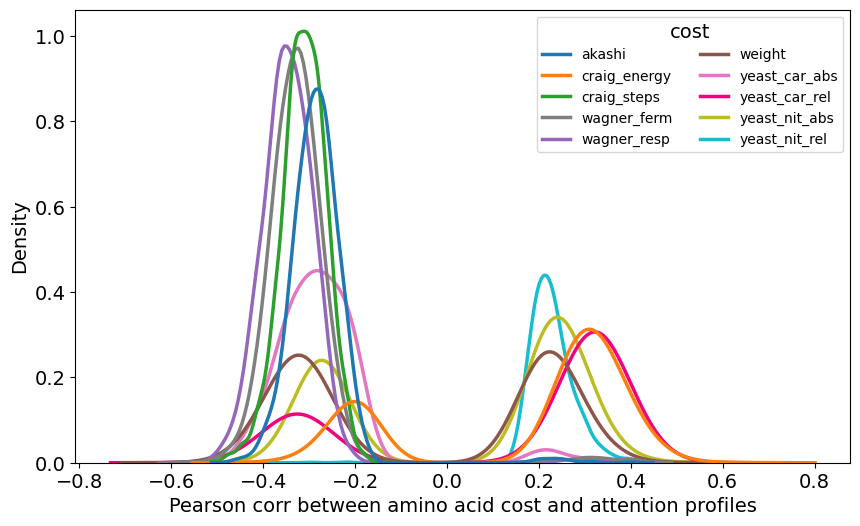

In [54]:
plt.figure(dpi = 100, figsize = (10, 6))

palette = sns.color_palette('tab10')
palette[3] = sns.color_palette('Accent')[-3]  # avoid pure red for colorblindness
# palette[7] = 'gray'  # better contrast
palette[3], palette[7] = palette[7], palette[3]
# palette[3] = sns.color_palette('Accent')[-1]  # avoid red-green


g = sns.kdeplot(data = cost_correlations, x = 'corr', hue='cost', 
                linewidth = 2.5, 
                palette=palette)
sns.move_legend(g, loc='upper right', ncol = 2, fontsize=10)

plt.xlabel('Pearson corr between amino acid cost and attention profiles')

plt.savefig('attention_cost_corr.pdf')

In [11]:
cost_correlations.to_csv('att_cost_corr.csv', index=False)

## Separate pos / neg correlates

In [12]:
seq_data_and_corr = pd.merge(
    cost_correlations.assign(
        corr_sense = cost_correlations['corr'].map(lambda v: 'pos' if v > 0 else 'neg')
    ),
    seq_data[['swissprot_ac', 'Median_molecules_per_cell']],
    
    on = 'swissprot_ac'
)

seq_data_and_corr = seq_data_and_corr.assign(
    log_Median_molecules_per_cell = np.log(seq_data_and_corr['Median_molecules_per_cell'])
)

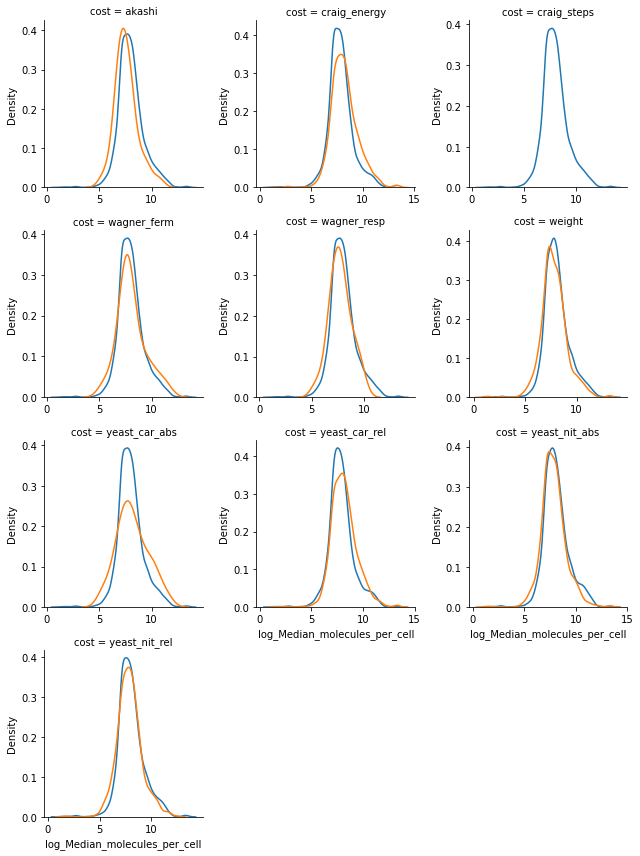

In [13]:
g = sns.FacetGrid(data = seq_data_and_corr, hue='corr_sense', col = 'cost', 
                  col_wrap=3, sharex=False, sharey=False)

g.map(sns.kdeplot, 'log_Median_molecules_per_cell')

plt.tight_layout()

In [14]:
_p_corr_stats = (
    cost_correlations.query('corr > 0')
    .groupby('cost')
    .agg(['mean', 'count'])
    .droplevel(level = 1, axis = 'columns')
    .reset_index()
)
_p_corr_stats.columns = ['cost', 'mean_corr', 'count']


left_align(
    pd.merge(
        _p_corr_stats.sort_values('mean_corr', ascending=False),
        cost_descr, 
        on = 'cost'
    )
)

/tmp/ipykernel_35242/2014750577.py:2: FutureWarning: ['swissprot_ac'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  cost_correlations.query('corr > 0')


,cost,mean_corr,count,descr
0,yeast_car_rel,0.322725,1855,Imapct of rel. change of the AA requirement on the minimal intake of C (glucose) [Barton et al. 2010]
1,craig_energy,0.319014,1848,Energetic cost (avg. n. units of high energy P bonds and reducing H atoms) [Craig & Weber 1998]
2,wagner_resp,0.309522,32,Respiratory cost (similar to Craig & Weber) [Wagner 2005]
3,wagner_ferm,0.309046,66,Fermentative cost (similar to Craig & Weber) [Wagner 2005]
4,yeast_nit_abs,0.248459,1833,Imapct of abs. change of the AA requirement on the minimal intake of N (ammonium) [Barton et al. 2010]
5,akashi,0.244109,33,Energetic cost (avg. n. units of high energy P bonds and reducing H atoms) [Akashi & Gojobori 2002]
6,yeast_car_abs,0.241446,121,Imapct of abs. change of the AA requirement on the minimal intake of C (glucose) [Barton et al. 2010]
7,weight,0.230809,1438,Molecular weight of the amino acid [Seligmann 2003]
8,yeast_nit_rel,0.230152,1422,Imapct of rel. change of the AA requirement on the minimal intake of N (ammonium) [Barton et al. 2010]


In [15]:
_n_corr_stats = (
    cost_correlations.query('corr < 0')
    .groupby('cost')
    .agg(['mean', 'count'])
    .droplevel(level = 1, axis = 'columns')
    .reset_index()
)
_n_corr_stats.columns = ['cost', 'mean_corr', 'count']

left_align(
    pd.merge(
        _n_corr_stats.sort_values('mean_corr'),
        cost_descr, 
        on = 'cost'
    )
)

/tmp/ipykernel_35242/2426255025.py:2: FutureWarning: ['swissprot_ac'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  cost_correlations.query('corr < 0')


,cost,mean_corr,count,descr
0,wagner_resp,-0.346841,4226,Respiratory cost (similar to Craig & Weber) [Wagner 2005]
1,wagner_ferm,-0.329704,4057,Fermentative cost (similar to Craig & Weber) [Wagner 2005]
2,yeast_car_rel,-0.328086,705,Imapct of rel. change of the AA requirement on the minimal intake of C (glucose) [Barton et al. 2010]
3,weight,-0.325723,1472,Molecular weight of the amino acid [Seligmann 2003]
4,craig_steps,-0.311740,3932,The number of biosynthetic steps between central metabolism and the resulting AA [Craig & Weber 1998]
5,yeast_nit_rel,-0.289971,4,Imapct of rel. change of the AA requirement on the minimal intake of N (ammonium) [Barton et al. 2010]
6,yeast_car_abs,-0.289392,2797,Imapct of abs. change of the AA requirement on the minimal intake of C (glucose) [Barton et al. 2010]
7,akashi,-0.286920,3341,Energetic cost (avg. n. units of high energy P bonds and reducing H atoms) [Akashi & Gojobori 2002]
8,yeast_nit_abs,-0.272822,1165,Imapct of abs. change of the AA requirement on the minimal intake of N (ammonium) [Barton et al. 2010]
9,craig_energy,-0.209371,684,Energetic cost (avg. n. units of high energy P bonds and reducing H atoms) [Craig & Weber 1998]


In [16]:
pos_neg_corr = (
    pd.merge(
        _p_corr_stats,
        _n_corr_stats,
        on = 'cost',
        how = 'outer',
        suffixes=('_positive', '_negative')
    )
    .sort_values('mean_corr_positive', ascending=False)
    .merge(
        cost_descr
    )
)

pos_neg_corr['count_positive'] = pos_neg_corr['count_positive'].fillna(0).astype('int')

left_align(
    pos_neg_corr
)

,cost,mean_corr_positive,count_positive,mean_corr_negative,count_negative,descr
0,yeast_car_rel,0.322725,1855,-0.328086,705,Imapct of rel. change of the AA requirement on the minimal intake of C (glucose) [Barton et al. 2010]
1,craig_energy,0.319014,1848,-0.209371,684,Energetic cost (avg. n. units of high energy P bonds and reducing H atoms) [Craig & Weber 1998]
2,wagner_resp,0.309522,32,-0.346841,4226,Respiratory cost (similar to Craig & Weber) [Wagner 2005]
3,wagner_ferm,0.309046,66,-0.329704,4057,Fermentative cost (similar to Craig & Weber) [Wagner 2005]
4,yeast_nit_abs,0.248459,1833,-0.272822,1165,Imapct of abs. change of the AA requirement on the minimal intake of N (ammonium) [Barton et al. 2010]
5,akashi,0.244109,33,-0.286920,3341,Energetic cost (avg. n. units of high energy P bonds and reducing H atoms) [Akashi & Gojobori 2002]
6,yeast_car_abs,0.241446,121,-0.289392,2797,Imapct of abs. change of the AA requirement on the minimal intake of C (glucose) [Barton et al. 2010]
7,weight,0.230809,1438,-0.325723,1472,Molecular weight of the amino acid [Seligmann 2003]
8,yeast_nit_rel,0.230152,1422,-0.289971,4,Imapct of rel. change of the AA requirement on the minimal intake of N (ammonium) [Barton et al. 2010]
9,craig_steps,nan,0,-0.311740,3932,The number of biosynthetic steps between central metabolism and the resulting AA [Craig & Weber 1998]


### Ranking of costs by abs mean correlation

In [17]:
cost_ranking = (
    cost_correlations.assign(
        abs_corr = cost_correlations['corr'].map(np.abs)
    )
    .groupby('cost')['abs_corr']
    .mean()
    .sort_values(ascending=False).reset_index()
)

cost_ranking = pd.merge(
    cost_ranking, cost_descr, on='cost'
)

In [18]:
with pd.option_context('display.max_colwidth', 120):
    display(left_align(cost_ranking))

,cost,abs_corr,descr
0,wagner_resp,0.346560,Respiratory cost (similar to Craig & Weber) [Wagner 2005]
1,wagner_ferm,0.329373,Fermentative cost (similar to Craig & Weber) [Wagner 2005]
2,yeast_car_rel,0.324201,Imapct of rel. change of the AA requirement on the minimal intake of C (glucose) [Barton et al. 2010]
3,craig_steps,0.311740,The number of biosynthetic steps between central metabolism and the resulting AA [Craig & Weber 1998]
4,craig_energy,0.289395,Energetic cost (avg. n. units of high energy P bonds and reducing H atoms) [Craig & Weber 1998]
5,yeast_car_abs,0.287404,Imapct of abs. change of the AA requirement on the minimal intake of C (glucose) [Barton et al. 2010]
6,akashi,0.286502,Energetic cost (avg. n. units of high energy P bonds and reducing H atoms) [Akashi & Gojobori 2002]
7,weight,0.278821,Molecular weight of the amino acid [Seligmann 2003]
8,yeast_nit_abs,0.257926,Imapct of abs. change of the AA requirement on the minimal intake of N (ammonium) [Barton et al. 2010]
9,yeast_nit_rel,0.230320,Imapct of rel. change of the AA requirement on the minimal intake of N (ammonium) [Barton et al. 2010]


## Compare costs of successful mutants  (20% regime)

In [22]:
def calc_prot_costs(protein_id: str) -> pd.DataFrame:
    """Return total costs for the protein ID"""    
    costs_for_protein = {}
    for cost_name in cost_names:
        costs_for_protein[cost_name] = sequence_cost(sequence[protein_id], cost_name).sum()
        
    costs_for_protein = pd.DataFrame.from_records(list(costs_for_protein.items()),
                                                  columns=['cost', 'value'])
    costs_for_protein = costs_for_protein.assign(swissprot_ac = protein_id)
    return costs_for_protein[['swissprot_ac', 'cost', 'value']]


protein_costs = seq_data['swissprot_ac'].progress_map(
    calc_prot_costs
)
protein_costs = pd.concat(protein_costs.values, ignore_index=True)

Pandas op: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4750/4750 [00:40<00:00, 116.91it/s]


In [19]:
mut_res = pd.read_csv('informed_mutation/guided_mutation_results.csv.gz')
mut_res = mut_res.rename(columns = {'name': 'scheme'})
mut_ret = mut_res.query('scheme == "percent_20"')

In [20]:
def calc_seq_cost(seq: str, protein_id: str, partition_label: str):
    """Return total costs for the protein seq"""    
    costs_for_protein = {}
    for cost_name in cost_names:
        costs_for_protein[cost_name] = sequence_cost(seq, cost_name).sum()
        
    costs_for_protein = pd.DataFrame.from_records(list(costs_for_protein.items()),
                                                  columns=['cost', 'value'])
    costs_for_protein = costs_for_protein.assign(swissprot_ac = protein_id)
    return costs_for_protein[['swissprot_ac', 'cost', 'value']].assign(partition = partition_label)


mutant_protein_costs = pd.concat(
    (
        mut_ret.progress_apply(
            lambda row: calc_seq_cost(row['seq_mut'], row['swissprot_ac'], partition_label = 'mutant'),
            axis='columns'
        ).values.tolist()
        +
        mut_ret.progress_apply(
            lambda row: calc_seq_cost(row['seq_mut_control'], row['swissprot_ac'], partition_label = 'rand_ctrl'),
            axis='columns'
        ).values.tolist()
    ),
    ignore_index = True
)

Pandas op: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4745/4745 [00:42<00:00, 112.67it/s]


In [23]:
mutant_and_wt_protein_costs = pd.concat(
    [
        mutant_protein_costs,
        protein_costs.assign(partition = 'wt')
    ],
    ignore_index=True
)

mutant_and_wt_protein_costs = mutant_and_wt_protein_costs.rename(columns={'value': 'corr'})

In [24]:
def cost_delta(grp_df) -> float:
    cost = dict(grp_df[['partition', 'corr']].values)
    return pd.DataFrame.from_records(
        [(100 * (cost['mutant'] - cost['wt']) / cost['wt'], 'mutant'),
         (100 * (cost['rand_ctrl'] - cost['wt']) / cost['wt'], 'rand_ctrl')],
        columns = ['delta_percent', 'partition']
    )


cost_deltas = (
    mutant_and_wt_protein_costs
    .groupby(['swissprot_ac', 'cost'])
    .progress_apply(cost_delta)
    .reset_index().drop(columns='level_2')
)

Pandas op: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47450/47450 [00:58<00:00, 808.21it/s]


<Figure size 1000x600 with 0 Axes>

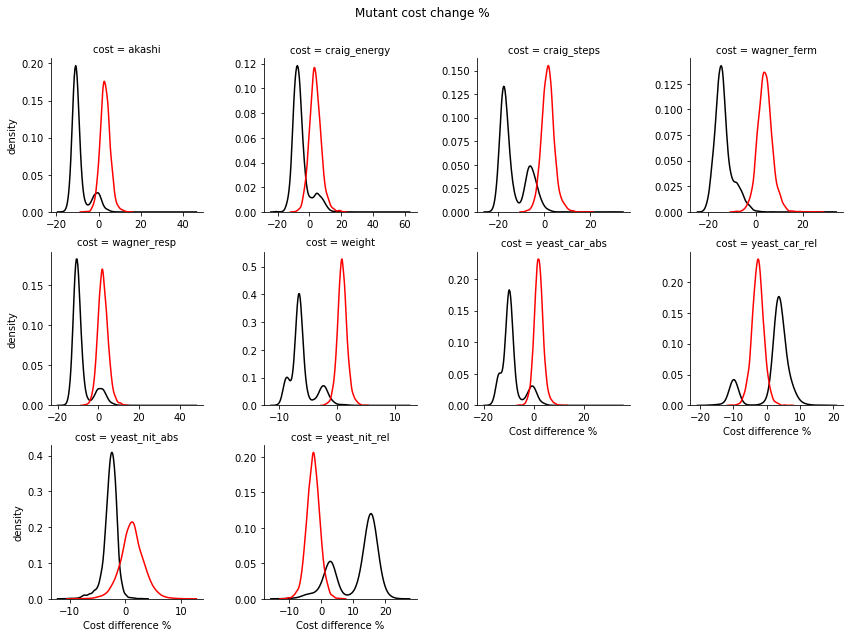

In [25]:
plt.figure(dpi=100, figsize=(10, 6))

g = sns.FacetGrid(cost_deltas, hue = 'partition', col='cost', 
                  palette = {'mutant': 'black', 'rand_ctrl': 'red'},
                  col_wrap = 4, legend_out=True,
                  sharex=False, sharey=False )

g.map_dataframe(sns.kdeplot, x='delta_percent')

g.set_axis_labels('Cost difference %', 'density')
_ = g.fig.subplots_adjust(top=0.9) 
_ = g.fig.suptitle('Mutant cost change %')

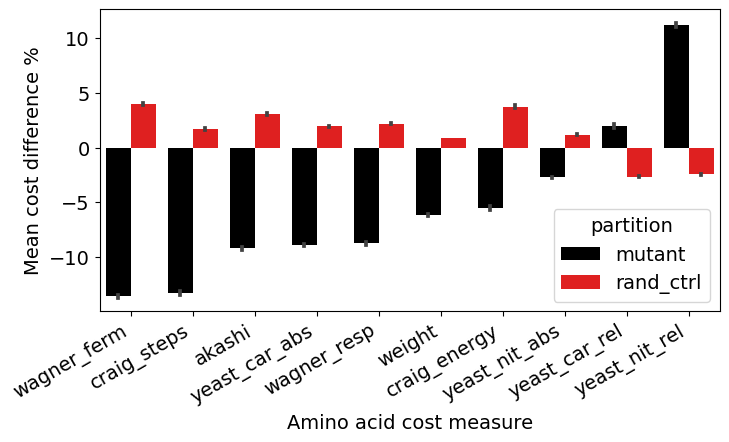

In [26]:
plt.rcParams['font.size'] = 14
plt.figure(dpi=100, figsize=(8, 4))

mean_cost_deltas = cost_deltas.groupby(['cost', 'partition'])['delta_percent'].mean().reset_index()

sns.barplot(
    data = cost_deltas,
    x = 'cost', y = 'delta_percent',
    hue = 'partition',
    order = mean_cost_deltas.query('partition == "mutant"').sort_values('delta_percent')['cost'].values,
    palette = {'mutant': 'black', 'rand_ctrl': 'red'},
)
plt.xticks(rotation=30, ha='right')

plt.xlabel('Amino acid cost measure')
plt.ylabel('Mean cost difference %')

plt.savefig('mean_cost_diff_mutants.pdf')

In [27]:
cost_deltas.to_csv('mean_cost_deltas_percent20.csv', index=False)

In [28]:
def assess_delta_significance(grp_df):
    mut_delta = grp_df.query('partition == "mutant"')['delta_percent'].values
    ctrl_delta = grp_df.query('partition == "rand_ctrl"')['delta_percent'].values
    return stats.ttest_rel(mut_delta, ctrl_delta)[1]


cost_deltas.groupby('cost').apply(assess_delta_significance)

cost
akashi           0.0
craig_energy     0.0
craig_steps      0.0
wagner_ferm      0.0
wagner_resp      0.0
weight           0.0
yeast_car_abs    0.0
yeast_car_rel    0.0
yeast_nit_abs    0.0
yeast_nit_rel    0.0
dtype: float64

In [29]:
cost_deltas.groupby(['cost', 'partition'])['delta_percent'].agg(['mean', 'median']).sort_values(['partition', 'mean'])

,,mean,median
cost,partition,,
wagner_ferm,mutant,-13.603179,-14.278455
craig_steps,mutant,-13.306743,-16.036655
akashi,mutant,-9.218666,-10.467478
yeast_car_abs,mutant,-8.899055,-9.736461
wagner_resp,mutant,-8.736643,-10.243985
weight,mutant,-6.159937,-6.564234
craig_energy,mutant,-5.551885,-6.854130
yeast_nit_abs,mutant,-2.709100,-2.564103
yeast_car_rel,mutant,1.978379,3.525594


In [30]:
mean_cost_changes = (
    cost_deltas
    .groupby(['cost', 'partition']).mean()
    .reset_index()
    .sort_values(['partition', 'delta_percent'])
)

pd.merge(
    mean_cost_changes.query('partition == "mutant"'),
    mean_cost_changes.query('partition == "rand_ctrl"'),
    on = 'cost',
    suffixes = ('_mutant', '_control')
).drop(columns = ['partition_mutant', 'partition_control'])

,cost,delta_percent_mutant,delta_percent_control
0,wagner_ferm,-13.603179,3.933833
1,craig_steps,-13.306743,1.682922
2,akashi,-9.218666,3.059934
3,yeast_car_abs,-8.899055,1.926197
4,wagner_resp,-8.736643,2.193350
5,weight,-6.159937,0.863105
6,craig_energy,-5.551885,3.734348
7,yeast_nit_abs,-2.709100,1.179117
8,yeast_car_rel,1.978379,-2.667477
9,yeast_nit_rel,11.187093,-2.451302
